In [1]:
### Installing the required packages 

!pip install pandas
!pip install quandl
!pip install matplotlib
!pip install yfinance
!pip install python-dotenv

In [14]:
import pandas as pd 
import os
import quandl
import random
import matplotlib.pyplot as plt
from datetime import date
from dotenv import load_dotenv
import warnings


## this is to ignore the df.mean() and df.median() run on the ukr_rus_df
warnings.filterwarnings('ignore')

In [3]:
###loading the .env environment variables

load_dotenv()

True

In [4]:
## getting the environment variables
q_API_KEY = os.getenv('QUANDL_API_KEY')

In [5]:
## setting up the API key
quandl.ApiConfig.api_key = q_API_KEY

In [6]:
## Using Zillow to get historical data to get data for UK_RUS housing prices 

zillow_indicators = quandl.get_table("ZILLOW/INDICATORS", paginate=True)

## Since we are looking at home values

mask = zillow_indicators['category']=='Home values'
## This df describes the indicators present in the data set. We are going to use the 
## the ZALL indicatro (ZHVI All Homes(SFR, Condo/Co-op))
home_values_ind = zillow_indicators[mask]

## getting the zillow regions available on the API
zillow_regions = quandl.get_table('ZILLOW/REGIONS', paginate= True)




In [7]:
### All the States in the US
states = ['IA', 'KS', 'UT', 'VA', 'NC', 'NE', 'SD', 'AL', 'ID', 'FM', 'DE', 'AK', 'CT', 'PR', 'NM', 'MS', 'PW', 'CO', 'NJ', 'FL', 'MN', 'VI', 'NV', 'AZ', 'WI', 'ND', 'PA', 'OK', 'KY', 'RI', 'NH', 'MO', 'ME', 'VT', 'GA', 'GU', 'AS', 'NY', 'CA', 'HI', 'IL', 'TN', 'MA', 'OH', 'MD', 'MI', 'WY', 'WA', 'OR', 'MH', 'SC', 'IN', 'LA', 'MP', 'DC', 'MT', 'AR', 'WV', 'TX']

##  The zip region column is list of strings we will use the zip field to find the state in which
##  the region exists. 
## function to get the states in the region_field

def state_check(search_field): 
    ## separating the search field data set into a list
    search_field = [elem.strip() for elem in search_field.split(";")]
    
    for elem in search_field:
        if elem in states: 
            return elem
        
## creating a state field. Using the zip region 
mask = zillow_regions['region_type']=='zip'

zillow_regions_zip = zillow_regions[mask].copy()

## Creating a state column using the state_check function
zillow_regions_zip['state'] = zillow_regions_zip.apply(lambda x: state_check(x['region']), axis =1)

zillow_regions_zip

,region_id,region_type,region,state
None,,,,
0,99999,zip,98847; WA; Wenatchee; Chelan County; Peshastin,WA
1,99998,zip,98846; WA; Okanogan County; Pateros,WA
2,99997,zip,98845; WA; Wenatchee; Douglas County; Palisades,WA
3,99996,zip,98844; WA; Okanogan County; Oroville,WA
4,99995,zip,98843; WA; Wenatchee; Douglas County; Orondo,WA
...,...,...,...,...
79243,100004,zip,98852; WA; Okanogan County; Winthrop,WA
79244,100003,zip,98851; WA; Moses Lake; Grant County; Soap Lake,WA
79245,100002,zip,98850; WA; Wenatchee; Douglas County; Rock Island,WA


In [8]:
## loop to get the house market prices for all the states. 
## since each state could have several region_ids in excess of a 1000, 
## I use a random sample of 30 from each state to calculate the average housing prices 
## of each state
## This part might take some time and therefore you should give it about 5-10 minutes to complete
## The function will print out the iteration number to show its progress. Ends at iteration 58


for id, state in enumerate(states):
    
    ## getting the rows with the current state value
    mask = zillow_regions_zip['state']==state
    
    ## filtering the rows out in the dataframe
    zillow_ak = zillow_regions_zip[mask]
    
    ##getting the region_ids for that particular state
    region_ids = zillow_ak['region_id'].unique()
    
    ## to monitor the progress
    print(id)
    ## creating a list of the region ids so as to get that with those particular IDs
    ids = list(region_ids)
    
    
    
    ## Checking if ids are greater than 100 since we are only going to pick a random sample of 100
    if len(ids)>100:
        r_ids = random.sample(ids, 30)
    elif len(ids)==0:
        continue
    else: 
        r_ids = ids
    
      
    ### getting the dataframe containing the house prices using the ZALL indicator id from the home_values_ind 
    ## dataframe
    df = quandl.get_table('ZILLOW/DATA', indicator_id="ZALL", region_id=r_ids , paginate = True)
    
    ### grouping the values by date and then finding the average
    
    data = df.groupby(['date'])['value'].mean()
    
    ## Checking if it is the first iteration: 
    if id==0: 
        data_df = pd.DataFrame(data)
        data_df.rename(columns = {'value': state}, inplace = True)
        data_df.reset_index(inplace = True)
    else:
        new_df = pd.DataFrame(data)
        new_df.rename(columns = {'value': state}, inplace = True)
        new_df.reset_index(inplace = True)
        data_df = pd.merge(data_df, new_df, how = 'left')
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


In [15]:
## getting recent data for the uk-rus invasion 
mask = data_df['date']>="2021-09-01"

## recent data containing average prices for every month from 6 months before the war for every state
ukr_rus_df = data_df[mask].copy()

ukr_rus_df = ukr_rus_df.round(2)

## Calculating the national average
ukr_rus_df['national_average'] = ukr_rus_df.mean(axis=1).round(2)

ukr_rus_df['national_median'] = ukr_rus_df.median(axis=1).round(2)

ukr_rus_df

,date,IA,KS,UT,VA,NC,NE,SD,AL,ID,...,SC,IN,LA,DC,MT,AR,WV,TX,national_average,national_median
308,2021-09-30,156468.41,158164.88,412721.69,233661.00,192874.31,181196.17,189991.65,142964.07,313829.66,...,198380.79,178367.37,139929.69,670978.50,378421.64,121653.07,98626.71,228106.90,289973.00,230883.95
309,2021-10-31,157224.90,159698.62,420441.21,235436.17,196418.72,182500.63,191427.30,144672.50,317446.17,...,201900.50,180226.27,140916.66,672519.00,383411.21,123112.07,99322.46,231295.50,293388.15,233365.84
310,2021-11-30,158236.14,160795.58,426948.10,236682.63,199756.59,184179.83,192583.78,146165.36,319101.86,...,204963.64,182169.57,141684.17,671411.12,387196.57,124564.10,100249.54,233781.63,296327.18,235232.13
311,2021-12-31,159778.55,162482.04,435533.69,239649.67,206436.25,187056.30,195446.43,149599.19,327696.24,...,208696.07,185232.17,143438.79,671481.88,393789.71,126720.80,102171.46,237554.70,300336.12,238602.18
312,2022-01-31,158630.77,163846.19,445068.66,245352.87,208544.41,190369.37,198757.26,151401.93,332121.67,...,212837.50,188149.03,142192.90,673267.75,402504.79,129065.00,103776.71,242305.00,305157.74,243828.94
313,2022-02-28,160423.87,162915.67,455537.38,249281.83,212794.48,196098.90,202045.26,153946.75,342254.40,...,217328.46,191908.13,144183.47,680615.88,414221.25,131908.40,106566.96,248597.20,310705.51,248939.52
314,2022-03-31,175185.85,169396.08,485126.32,253458.24,220150.12,192842.00,219927.81,135328.54,362930.08,...,208146.73,201576.41,154357.59,574671.71,418015.91,134805.68,111245.87,264057.64,319138.41,258757.94
315,2022-04-30,176055.69,172887.80,493668.72,255436.24,224746.12,194255.63,217095.18,137833.23,367763.29,...,211399.08,203921.07,154508.27,574805.71,421017.05,136587.32,113439.17,268657.61,323433.48,262046.92
316,2022-05-31,177477.38,173911.68,501314.32,255404.21,228601.92,195377.00,209757.00,139048.50,369972.17,...,214553.85,205560.07,155907.41,575535.00,414464.87,137846.88,114315.67,273393.14,326667.51,264689.07
317,2022-06-30,179175.31,177669.79,507904.40,259198.97,229691.32,197221.41,217191.06,140338.62,375059.42,...,218004.62,207659.04,157474.91,574220.29,423949.35,139324.32,115302.00,278073.04,330657.32,268636.00


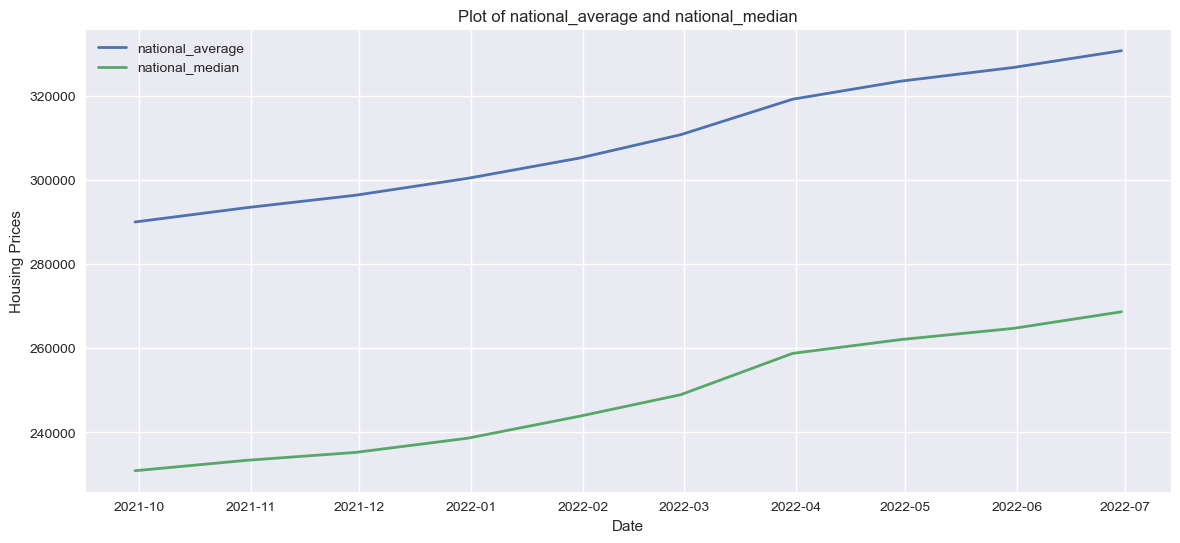

In [16]:
## plotting the national average and national median 
ukr_rus_plot_df = ukr_rus_df.set_index('date')


cols =['national_average', 'national_median']

fig,ax = plt.subplots(1,1, figsize = (14,6))
plt.style.use('seaborn')

for c in cols: 
    ax.plot(c, linewidth=2, data=ukr_rus_plot_df)
    ax.set_title('Plot of national_average and national_median')
    plt.xlabel('Date')
    plt.ylabel('Housing Prices')

    handles,labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper left', prop = {"size":10})

plt.show()

In [11]:
## Gulf war housing prices index. There's limited out there for this luckily FRED has quartely data for
## housing prices in the 1990s.
## Zillow housing data starts in 1996
# For some reason quandle cannot read the QUSR628BIS
## downloaded the xls filefrom here https://fred.stlouisfed.org/series/QUSR628BIS

df = pd.read_csv('gulf_war_index.csv')


df['observation_date'] = pd.to_datetime(df['observation_date'])

df.rename(columns = {'QUSR628BIS': 'quarterly_housing_prices'}, inplace = True)

In [12]:
## gettting data from 1990-02-1 to 1991-02-28
## since it's quarterly, 

mask1 = df['observation_date'] >= "1990-01-1"

mask2 = df['observation_date'] <= "1991-03-01"

mask = mask1&mask2

gulf_df = df[mask]

gulf_df

,observation_date,quarterly_housing_prices
80,1990-01-01,93.8162
81,1990-04-01,93.1032
82,1990-07-01,91.2690
83,1990-10-01,89.3036
84,1991-01-01,88.1170


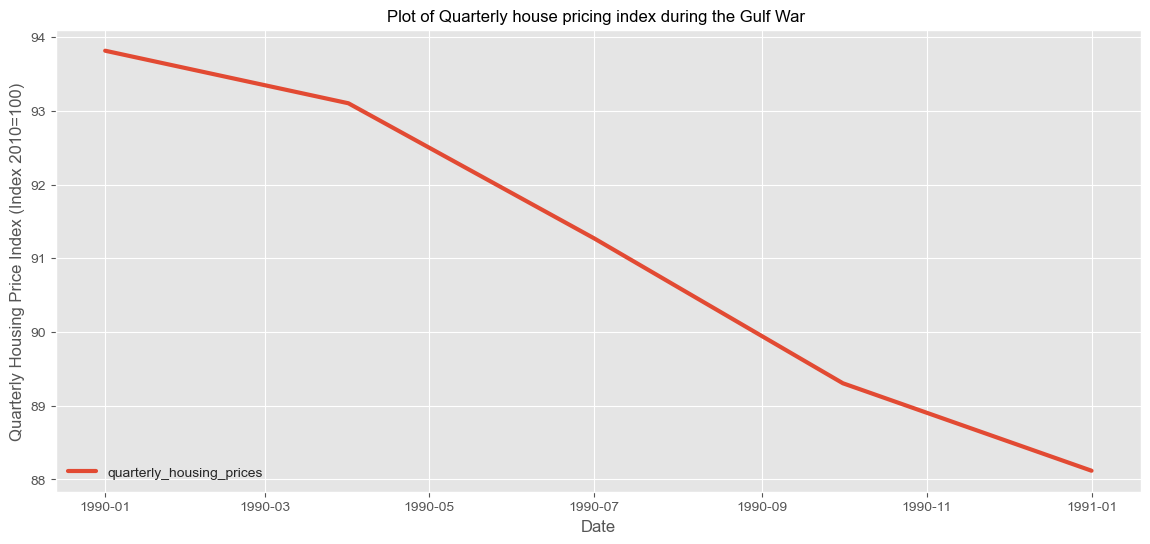

In [13]:
## plotting the quartely pricing index for the gulf war. 
gulf_plot_df = gulf_df.set_index('observation_date')

fig,ax = plt.subplots(1,1, figsize = (14,6))
plt.style.use('seaborn')

ax.plot('quarterly_housing_prices', linewidth=3, data=gulf_plot_df)
ax.set_title('Plot of Quarterly house pricing index during the Gulf War ')
plt.xlabel('Date')
plt.ylabel('Quarterly Housing Price Index (Index 2010=100)')

handles,labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='lower left', prop = {"size":10})

plt.show()